In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from datasets import load_dataset
import matplotlib.pyplot as plt
import flax.linen as nn
from jax.random import split, PRNGKey
from aevb import AEVB
from aevb import reparameterized_sample_loc_scale

def one_hot_encode(x, k):
    "Create a one-hot encoding of x of size k."
    return jnp.array(x[:, None] == jnp.arange(k), dtype=jnp.float32)


@jax.jit
def prepare_data(X):
    num_examples = X.shape[0]
    num_pixels = 28 * 28
    X = X.reshape(num_examples, num_pixels)
    X = X / 255.0

    return X, num_examples


def data_stream(seed, data, batch_size, data_size):
    """Return an iterator over batches of data."""
    rng = np.random.RandomState(seed)
    num_batches = int(jnp.ceil(data_size / batch_size))
    while True:
        perm = rng.permutation(data_size)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size : (i + 1) * batch_size]
            yield data[batch_idx]

class MlpEncoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=512)(x)
        x = nn.relu(x)
        x = nn.Dense(features=512)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        z_mu = nn.Dense(features=64)(x)
        z_sigma = nn.Dense(features=64)(x)
        z_sigma = jnp.exp(z_sigma * 0.5)
        return z_mu, z_sigma


class MlpDecoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(784)(x)
        return x
    

def simple_mlp_test(encoder, decoder, x_shape, z_shape):
    key = PRNGKey(144)

    key, subkey1, subkey2, subkey3 = split(key, 4)
    encoder_params = encoder.init(subkey1, jnp.ones(x_shape))
    decoder_params = decoder.init(subkey2, jnp.ones((1, z_shape)))

    # Test shapes
    z_mu, z_sigma = encoder.apply(encoder_params, jnp.ones(x_shape))
    z_samples = reparameterized_sample_loc_scale(subkey3, z_mu, z_sigma, 1)
    z = z_samples.mean(axis=0)
    x = decoder.apply(decoder_params, z)
    assert x.shape[0] == x_shape

In [3]:
# -------------------------------- Data --------------------------------
mnist_data = load_dataset("mnist")
data_train, data_test = mnist_data["train"], mnist_data["test"]

X_train = np.stack([np.array(example["image"]) for example in data_train])
X_test = np.stack([np.array(example["image"]) for example in data_test])

X_train, N_train = prepare_data(X_train)
X_test, N_test = prepare_data(X_test)

key = PRNGKey(155)
n = N_train.item()
seed = 1
batch_size = 100
batches = data_stream(seed, X_train, batch_size, n)

In [4]:
simple_mlp_test(
    MlpEncoder(),
    MlpDecoder(),
    x_shape=X_train.shape[-1],
    z_shape=64,
)

In [13]:
encoder = MlpEncoder()
decoder = MlpDecoder()
z_shape = 64

simple_mlp_test(
    encoder,
    decoder,
    x_shape=X_train.shape[-1],
    z_shape=64,
)

optimizer = optax.adam(1e-3)

aevb = AEVB.init(
    recognition_apply=encoder.apply,
    generative_apply=decoder.apply,
    optimizer=optimizer,
    n_samples=1,
)

key = PRNGKey(122)
key, init_key1, init_key2 = split(key, 3)

rec_params = encoder.init(init_key1, jnp.ones(X_train.shape[-1]))
gen_params = decoder.init(init_key2, jnp.ones(z_shape))

state = aevb.init(rec_params, gen_params)


In [14]:
num_steps = 8000
eval_every = 100

keys = split(key, num_steps)
for i, rng_key in enumerate(keys):
    batch = next(batches)
    state, info = jax.jit(aevb.step)(rng_key, state, batch)

    if i % eval_every == 0:
        print(f"Step {i} | loss: {info.loss} | nll: {info.nll} | kl: {info.kl}")



Step 0 | loss: 31270.32421875 | nll: 31262.65625 | kl: 7.668425559997559
Step 100 | loss: 5416.97265625 | nll: 5334.04248046875 | kl: 82.93014526367188
Step 200 | loss: 5380.427734375 | nll: 5308.30029296875 | kl: 72.12739562988281
Step 300 | loss: 5218.76171875 | nll: 5138.06494140625 | kl: 80.69679260253906
Step 400 | loss: 5245.00048828125 | nll: 5179.7685546875 | kl: 65.23204040527344
Step 500 | loss: 5079.68701171875 | nll: 4996.01123046875 | kl: 83.67570495605469
Step 600 | loss: 5215.8212890625 | nll: 5117.14208984375 | kl: 98.67933654785156
Step 700 | loss: 4986.6689453125 | nll: 4887.3251953125 | kl: 99.34361267089844
Step 800 | loss: 5146.7587890625 | nll: 5046.0302734375 | kl: 100.72832489013672
Step 900 | loss: 5083.75 | nll: 4933.732421875 | kl: 150.01766967773438
Step 1000 | loss: 4773.3720703125 | nll: 4599.81494140625 | kl: 173.55709838867188
Step 1100 | loss: 4772.07666015625 | nll: 4565.09765625 | kl: 206.97915649414062
Step 1200 | loss: 4757.59521484375 | nll: 4575.6

In [15]:
def plot_reconstructions(rng_key):
    fig, axs = plt.subplots(3, 2)
    for i in range(3):
        rng_key, subkey = split(rng_key)
        x_test = X_test[np.random.randint(0, len(X_test))]
        z_mu, z_sigma = encoder.apply(state.rec_params, x_test)
        z = reparameterized_sample_loc_scale(subkey, z_mu, z_sigma, 1)
        x_test_pred = decoder.apply(state.gen_params, z)
        axs[i][0].imshow(x_test.reshape(28, 28))
        axs[i][1].imshow(x_test_pred.reshape(28, 28))
    fig.show()
    
def plot_random(rng_key):
    fig, axs = plt.subplots(3, 2)
    for i in range(3):
        rng_key, subkey = split(rng_key)
        z = jax.random.normal(subkey, shape=(1, 64))
        x = decoder.apply(state.gen_params, z)
        axs[i][0].imshow(x.reshape(28, 28))

        rng_key, subkey = split(rng_key)
        z = jax.random.normal(subkey, shape=(1, 64))
        x = decoder.apply(state.gen_params, z)
        axs[i][1].imshow(x.reshape(28, 28))
    fig.show()



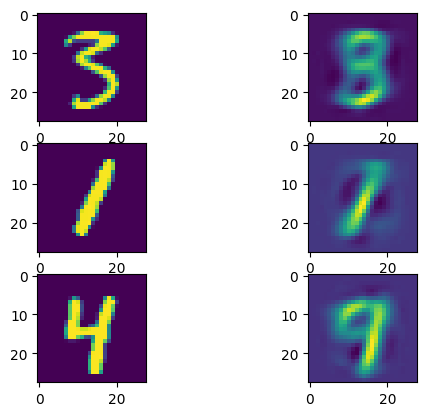

In [16]:
plot_reconstructions(PRNGKey(184))

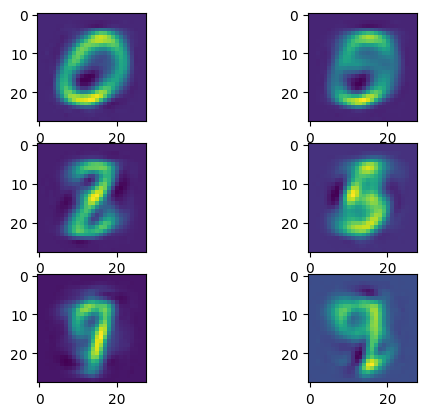

In [17]:
plot_random(PRNGKey(433))